The parameters chosen here are taken from the original research paper "A Neural Algorithm of Artistic style" https://arxiv.org/pdf/1508.06576.pdf 

Importing the libraries.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io

Loading, reshaping and normalizing the content image.

In [ ]:
content = plt.imread('img1.jpg')
content = np.reshape(content,((1,)+content.shape))
content = content - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [ ]:
plt.imshow(content[0])

Loading, reshaping and normalizing the style image.

In [ ]:
style = plt.imread('img2.jpg')
style = np.reshape(style,((1,)+style.shape))
style = style - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [ ]:
plt.imshow(style[0])

Defining a fuction to load the VGG19 pre-trained model. Took this from the Coursera notebook on 

In [ ]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

Loading the VGG19 pretrained model.

In [ ]:
model = load_vgg_model('imagenet-vgg-verydeep-19.mat')

A function comp_ccost is defined to calculate the content cost w.r.t Generated Image.

In [ ]:
def comp_ccost(a_C,a_G):
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    cost = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    return cost


We need to compute a gram matric of the form $A.A^{T}$ to be compute the cost of the style w.r.t Generated Image. A function c_gram(A) is defined for the same.

In [ ]:
def c_gram(A):
    g = tf.matmul(A,tf.transpose(A))
    return g

We need a function to take a layer of the VGG19 neural net and compute the cost.

In [ ]:
def c_lscost(a_S,a_G):
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    a_S_unrolled = tf.transpose(tf.reshape(a_S,shape=[n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape=[n_H * n_W, n_C]))
    gs = c_gram(a_S_unrolled)
    gg = c_gram(a_G_unrolled)
    cost = tf.reduce_sum(tf.square(tf.subtract(gs,gg)))/(4*n_C**2*(n_H*n_W)**2)
    return cost

We will be be merging style costs from different layers and according to the original research paper, the weight of each layer should be 1/$n^{l}$ where $n^{l}$ is the total number of layers whose style cost we will be merging.

In [ ]:
STYLE_LAYERS = [ ('conv1_1', 0.2), ('conv2_1', 0.2), ('conv3_1', 0.2), ('conv4_1', 0.2), ('conv5_1', 0.2)]

We will now be defining a function to iterate through the various layers of the Neural net and computing the cost.

In [ ]:
def comp_scost(model,STYLE_LAYERS):
    cost = 0
    for l_name,coeff in STYLE_LAYERS:
        out = model[l_name]
        a_S = sess.run(out)
        a_G = out
        cost_single_layer = c_lscost(a_S,a_G)
        cost += coeff*cost_single_layer
    return cost


We need to compute the total cost by defining a function and giving different weights to the content and style cost. Now as per the original research paper, we can choose these weights alpha and beta (alpha for style content and beta for style) such that we can make the generated image more content like or style like. I used alpha=1 and beta=0.001 to make the generated image content like. 

In [ ]:
def t_cost(comp_ccost,comp_scost,alpha,beta):
    c = alpha * comp_ccost + beta*comp_scost
    return c

We will be generating a random generated image by adding noise to the content Image.

In [ ]:
noise = np.random.uniform(-20,20,(content.shape)).astype('float32')

In [ ]:
g_image = noise*0.9 + content*0.1

In [ ]:
plt.imshow(g_image[0])


Starting a tensorflow session and loading the model and intializing the different varibles to cost functions so that they can be optimised. 

In [ ]:
tf.reset_default_graph()

sess = tf.InteractiveSession()


model = load_vgg_model('imagenet-vgg-verydeep-19.mat')
sess.run(model['input'].assign(content))

In [ ]:
out = model['conv4_2']

In [ ]:
a_C = sess.run(out)

In [ ]:
a_G = out

In [ ]:
J_content = comp_ccost(a_C,a_G)

In [ ]:
sess.run(model['input'].assign(style))

In [ ]:
J_style = comp_scost(model,STYLE_LAYERS)

In [ ]:
J = t_cost(J_content, J_style, alpha = 1, beta = 0.001)

We would be using an adam optimizer to optimize the model.

In [ ]:
optimizer = tf.train.AdamOptimizer(2)
train_step = optimizer.minimize(J)

We will now be putting it all together to calculate costs, optimize them and generate and image every 5 epochs. Do make a folder named op in the same directory as this notebook to keep the output images.

In [ ]:
def model_nst(sess,input_img,epochs):
    sess.run(tf.global_variables_initializer())
    model["input"].assign(input_img)
    for i in range(epochs):
        sess.run(train_step)
        g_image = sess.run(model['input'])
        Jt, Jc, Js = sess.run([J, J_content, J_style])
        print("Iteration " + str(i) + " :")
        print("total cost = " + str(Jt))
        print("content cost = " + str(Jc))
        print("style cost = " + str(Js))
        if i%5 == 0:
            image = g_image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
            image = np.clip(image[0], 0, 255).astype('uint8')
            plt.imsave('op/'+str(i)+'.png',image)
    image = g_image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imsave('op/final.png',image)
    return g_image


In [ ]:
model_nst(sess,g_image,2000)

Final Image with the provided content and style.

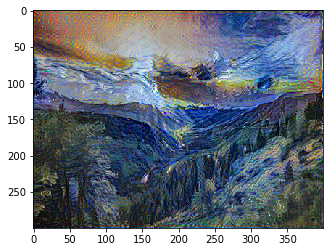

In [33]:
plt.imshow(plt.imread('op/final.png'))